In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
#Roller dimensions:
OD = 101.6 # 4" in mm
ID = 76.2 # 3" in mm

0.5
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text(0, 0.5, 'Height (mm)')

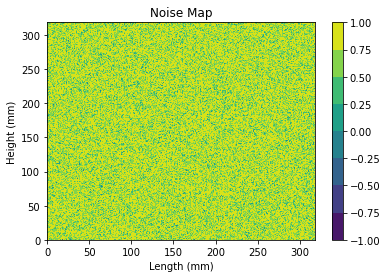

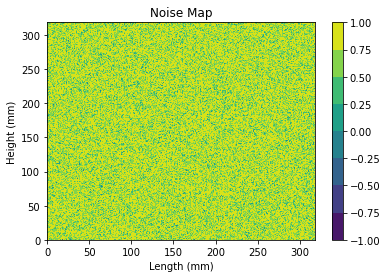

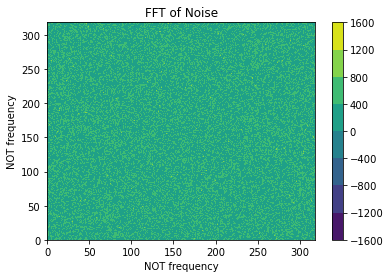

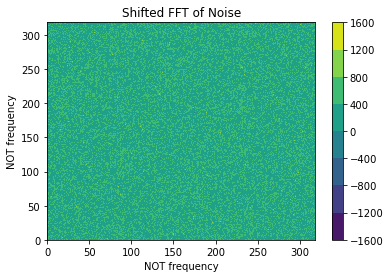

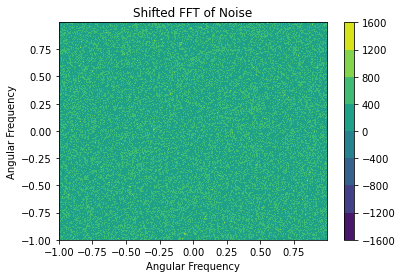

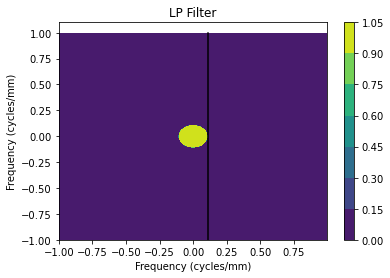

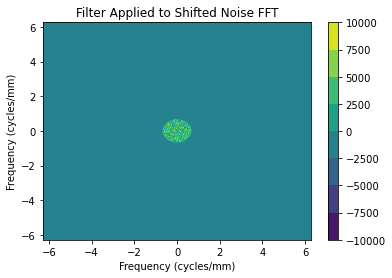

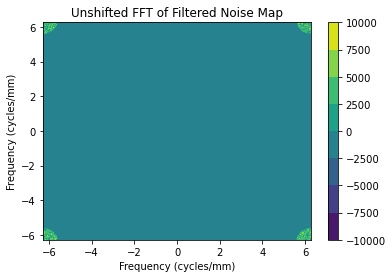

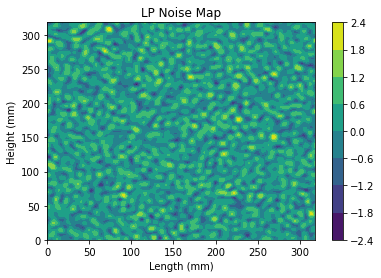

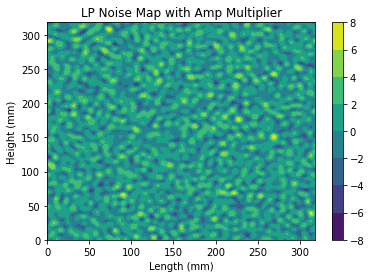

In [12]:
#Copied from Jared's code: 
### INITIALIZE ###
L = int(OD*np.pi) # circumference from OD
#print(L)
H = L  # Length of roller 
Nl = L * 2 #would L*2 be the Nyquist?
Nh = H * 2
dL = L/Nl #space between sample points
dH = H/Nh #these are equal - as they should be (?)
#print(dL,dH)
f = 100 #Hz or cycles/mm 75 works well for visualization
wc = (f / (2*np.pi))*(L/153.0) #rad/sec or rad/mm 
amp = 1 #amplitude +/- of noise
desired_featuresize = 5 #mm across
safety_mult = 2.8 #Extra multiplier term to even further increase % of 45deg facets

x = np.arange(0,L,dL)
y = np.arange(0,H,dH)
X,Y = np.meshgrid(x,y)

### ESTABLISH NOISE MAP ###
wn2d = np.random.uniform(-amp,amp,(Nh,Nl))
plt.figure()
plt.contourf(X,Y,wn2d)
plt.colorbar()
plt.title("Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### MAKE A PLANE WAVE ###

#wn2d = amp * np.sin(0.15 * Y) #########################
plt.figure()
plt.contourf(X,Y,wn2d)
plt.colorbar()
plt.title("Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### TAKE 2D FFT ###
wn2d_fft = np.fft.fft2(wn2d)
plt.figure()
plt.contourf(X,Y,wn2d_fft)
plt.colorbar()
plt.title("FFT of Noise")
plt.xlabel("NOT frequency")
plt.ylabel("NOT frequency")

### SHIFT THE FFT TO 0 ###
wn2d_shift = np.fft.fftshift(wn2d_fft)
plt.figure()
plt.contourf(X,Y,wn2d_shift)
plt.colorbar()
plt.title("Shifted FFT of Noise")
plt.xlabel("NOT frequency")
plt.ylabel("NOT frequency")

### CONVERT TO FERQUENCY AXIS DOMAIN ### I SUSPECT HERE IS WHERE THE ASYMMETRY HAPPENS
#freq bins - THESE NEED CHECKED
print(dL)
#freqs = np.fft.fftfreq((len(x),len(y)))
freqx = np.fft.fftshift(np.fft.fftfreq(x.shape[0],dL))
freqy = np.fft.fftshift(np.fft.fftfreq(y.shape[0],dH))
fX,fY = np.meshgrid(freqx, freqy)
#print(freqx)
#print(freqy)
plt.figure()
plt.contourf(fX,fY,wn2d_shift)
plt.colorbar()
plt.title("Shifted FFT of Noise")
plt.xlabel("Angular Frequency")
plt.ylabel("Angular Frequency")

### MAKE THE LP FILTER ###
#make lp filter
rows, cols = wn2d.shape
crow, ccol = int(rows/2), int(cols/2)
#lpf = np.zeros((rows, cols, 2))
lpf = np.zeros((rows, cols))
center = [crow, ccol]
xlpf, ylpf = np.ogrid[:rows, :cols]
lpf_area = (xlpf - center[0])**2 + (ylpf - center[1])**2 <= wc**2
lpf[lpf_area] = 1
#lpf = np.ones((Nl,Nh)) ############################ THIS CAN BE UNCOMMENTED TO STOP FILTER
print(lpf_area)
print(lpf)
plt.figure()
plt.contourf(freqx,freqy,lpf) #scaled from angular freq to Hz
plt.plot([0.111, 0.111], [-1, 1], '-k')
plt.colorbar()
plt.title("LP Filter")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### APPLY THE FILTER TO THE SHIFTED FFT ###
fftwn2d_lp = lpf*wn2d_shift * 10 ###THIS MULTIPLIER HERE WILL CHANGE THE DERIV CALC
plt.figure()
plt.contourf(2*np.pi*fX, 2*np.pi*fY, fftwn2d_lp)
plt.colorbar()
plt.title("Filter Applied to Shifted Noise FFT")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### UNSHIFT THE FILTERED FFT ###
fftwn2d_lp_unshift = np.fft.ifftshift(fftwn2d_lp)
plt.figure()
plt.contourf(2*np.pi*fX, 2*np.pi*fY, fftwn2d_lp_unshift)
plt.colorbar()
plt.title("Unshifted FFT of Filtered Noise Map")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### TAKE THE INVERSE FFT TO GET A FILTERED SIGNAL BACK ###
wn2d_lp = np.fft.ifft2(fftwn2d_lp_unshift)
plt.figure()
plt.contourf(X,Y,wn2d_lp)
plt.colorbar()
plt.title("LP Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### AMPLIFYING FEATURE SIZES TO INCREASE DERIVATIVES ###
#for significant % of 45deg derivatives
scale = desired_featuresize / 2
map_max = np.amax(np.abs(wn2d_lp))
multiplier = scale / map_max
wn2d_lp = wn2d_lp * multiplier * safety_mult
plt.figure()
plt.contourf(X,Y,wn2d_lp)
plt.colorbar()
plt.title("LP Noise Map with Amp Multiplier")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

In [16]:
wn2d_lp = np.real(wn2d_lp)

In [17]:
#Checking flat surface:

f = open("flat_noise_surface.txt",'w')

i=0
j=0

while i<np.shape(X)[0]:
    j=0
    while j<np.shape(X)[1]:
        f.write(str(X[i][j])+" "+str(Y[i][j])+" "+str(wn2d_lp[i][j])+'\n')
        j+=1
    i+=1

In [ ]:
#Checking RMS

np.save('wn2d_L42_W42_fc75_A1.npy', wn2d_lp)

wn2d_lp_real = wn2d_lp.real
#wn2d_lp_real = ['{:f}'.format(item) for item in wn2d_lp_real]

np.savetxt('lptest.txt', wn2d_lp.real, delimiter=',')

In [19]:
s = np.loadtxt('lptest.txt', delimiter=',')

s1d = s.flatten()
mu = np.mean(s1d)
print("mu = ",mu)
xi2 = (s1d - mu)**2
print(s1d[0:3])
print(xi2[0:3])

xsum = np.sum(xi2)
RMSE = np.sqrt(xsum / (len(xi2)))
print("RMSE = ",RMSE)

mu =  0.1130583772494563
[0.89170655 0.86882616 0.87777029]
[0.60629298 0.57118495 0.5847843 ]
RMSE =  1.799156026404392


In [20]:
#RMS is close to Jared's orignal (~1.8)

In [21]:
#Creating inverse noise surface:
wn2d_lp_inv = -1.0*wn2d_lp

In [32]:
#Creating cylindrical nosie surface

roller_rad = OD/2.0
phi = np.linspace(0,2*np.pi,np.shape(X)[1])

XC = np.empty_like(X)
YC = np.empty_like(Y)
ZC = np.empty_like(wn2d_lp)

i=0
j=0

while i<np.shape(X)[0]:
    j=0
    while j<np.shape(X)[1]:
        XC[i][j]= (roller_rad+wn2d_lp[i][j])*np.cos(phi[j]) 
        YC[i][j]= (roller_rad+wn2d_lp[i][j])*np.sin(phi[j])
        ZC[i][j]= Y[i][j]
        j+=1
    i+=1

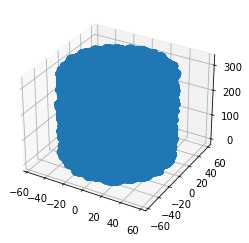

In [33]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XC,YC,ZC)

In [36]:
XC_inv = np.empty_like(X)
YC_inv = np.empty_like(Y)
ZC_inv = np.empty_like(wn2d_lp_inv)

i=0
j=0

while i<np.shape(X)[0]:
    j=0
    while j<np.shape(X)[1]:
        XC_inv[i][j]= (roller_rad+wn2d_lp_inv[i][j])*np.cos(phi[j])
        YC_inv[i][j]= (roller_rad+wn2d_lp_inv[i][j])*np.sin(phi[j]) 
        ZC_inv[i][j]= Y[i][j]
        j+=1
    i+=1

In [48]:
#Creating walls of cylindrical noise surface: 

x = []
y = []
z = []

i=0
j=0

#Creating inner wall:
while i<np.shape(Y)[0]:
    j=0
    while j<np.shape(Y)[1]:
        x.append((ID/2.0)*np.cos(phi[j]))
        y.append((ID/2.0)*np.sin(phi[j]))
        z.append(Y[i][j])
        j+=1
    i+=1

i=0
k=0.5

#Creating top and botom surfaces
while i<np.shape(Y)[1]:
    k=0.5
    while roller_rad-k>ID/2.0:
        x.append((roller_rad-k)*np.cos(phi[i]))
        y.append((roller_rad-k)*np.sin(phi[i]))
        z.append(0)
        x.append((roller_rad-k)*np.cos(phi[i]))
        y.append((roller_rad-k)*np.sin(phi[i]))
        z.append(Y[-1][-1]+0.5)
        k+=0.5      
    i+=1

print(roller_rad-k)

37.8


In [49]:
print(np.shape(Y)[1])
print(Y[-1][-1])
print(L)

638
318.5
319


In [50]:
x_inv = []
y_inv = []
z_inv = []

i=0
j=0

#Creating inner wall:
while i<np.shape(Y)[0]:
    j=0
    while j<np.shape(Y)[1]:
        x_inv.append((ID/2)*np.cos(phi[j]))
        y_inv.append((ID/2)*np.sin(phi[j]))
        z_inv.append(Y[i][j])
        j+=1
    i+=1

i=0
k=0.5

#Creating top and bottom surfaces: 
while i<np.shape(Y)[1]:
    k=0.5
    while roller_rad-k>ID/2.0:
        x_inv.append((roller_rad-k)*np.cos(phi[i]))
        y_inv.append((roller_rad-k)*np.sin(phi[i]))
        z_inv.append(0)
        x_inv.append((roller_rad-k)*np.cos(phi[i]))
        y_inv.append((roller_rad-k)*np.sin(phi[i]))
        z_inv.append(Y[-1][-1]+0.5)
        k+=0.5      
    i+=1


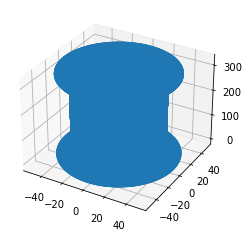

In [51]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)

In [52]:
f = open("roller3.txt",'w')

i=0
j=0

while i<np.shape(XC)[0]:
    j=0
    while j<np.shape(XC)[1]:
        f.write(str(XC[i][j])+" "+str(YC[i][j])+" "+str(ZC[i][j])+'\n')
        j+=1
    i+=1
    
k=0
while k<len(x):
    f.write(str(x[k])+" "+str(y[k])+" "+str(z[k])+"\n")
    k+=1


In [53]:
f = open("roller3_inv.txt",'w')

i=0
j=0

while i<np.shape(XC_inv)[0]:
    j=0
    while j<np.shape(XC_inv)[1]:
        f.write(str(XC_inv[i][j])+" "+str(YC_inv[i][j])+" "+str(ZC_inv[i][j])+'\n')
        j+=1
    i+=1
    
k=0
while k<len(x):
    f.write(str(x_inv[k])+" "+str(y_inv[k])+" "+str(z_inv[k])+"\n")
    k+=1
    